In [1]:
%matplotlib inline

import pymongo
import seaborn as sns

In [2]:
import pandas as pd

def group_by(df, bycols, agg_map):
    """

    @param df:      DataFrame
    @param bycols:  str or list
                        Column(s) to group by
    @param agg_map: dictionary or list of 2-tuples
                        Mapping from column to aggregate function e.g. [("city", "count"), ("salary", "mean"]
    @return:        DataFrame
                        Flattened dataframe, with multi-level index removed
    """
    grps = []
    if type(bycols) == str:
        bycols = [bycols]

    if type(agg_map) == dict:
        agg_map = agg_map.items()

    for k,v in agg_map:
        grp = df[bycols + [k]].groupby(bycols, ).agg(v)
        grp.reset_index(inplace=True)
        grp["%s(%s)" % (v,k)] = grp[k]
        del grp[k]
        grps.append(grp)

    m = grps[0]
    for grp in grps[1:]:
        m = pd.merge(m, grp, on=bycols, how="inner")
    return m

In [3]:
client = pymongo.MongoClient()
db = client.metrics

cb_td, cb_vd, sc_td, sc_vd = "CB_TAGGING_TD_FEAT_SELECTION", "CB_TAGGING_VD_FEAT_SELECTION", "SC_TAGGING_TD_FEAT_SELECTION", "SC_TAGGING_VD_FEAT_SELECTION"
cb_td, cb_vd, sc_td, sc_vd = db[cb_td], db[cb_vd], db[sc_td], db[sc_vd]
cb_td, cb_vd, sc_td, sc_vd

(Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), u'metrics'), u'CB_TAGGING_TD_FEAT_SELECTION'),
 Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), u'metrics'), u'CB_TAGGING_VD_FEAT_SELECTION'),
 Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), u'metrics'), u'SC_TAGGING_TD_FEAT_SELECTION'),
 Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), u'metrics'), u'SC_TAGGING_VD_FEAT_SELECTION'))

# Query Top Features

In [4]:
from pprint import pprint
from bson.son import SON # needed to ensure dictionary is ordered (python default is not)

feats_pipeline = [{
    "$project": { 
            "weighted_f1_score":"$WEIGHTED_MEAN_CONCEPT_CODES.f1_score",
            "micro_f1_score":  "$MICRO_F1.f1_score",
            "micro_recall":    "$MICRO_F1.recall",
            "micro_precision": "$MICRO_F1.precision",
            "window_size":    "$parameters.window_size",
            "feats":          "$parameters.extractors",
            "count": {        "$size" : "$parameters.extractors" },
            "asof" :          "$asof",
            "_id":1
    }
},
{
    "$match":{
        "micro_f1_score": { "$exists" : True },
        # how many feats
        #"count": {          "$eq" :1 },
        # window width
        #"window_size": {    "$eq":13 }
    }
},
{
    "$sort":{
        #"weighted_f1_score":-1,
        "micro_f1_score": -1
        #"asof": -1
        #"count": -1
    }
},
]

cb_td_rows = [row for row in cb_td.aggregate(feats_pipeline)]
cb_vd_rows = [row for row in cb_vd.aggregate(feats_pipeline)]
sc_td_rows = [row for row in sc_td.aggregate(feats_pipeline)]
sc_vd_rows = [row for row in sc_vd.aggregate(feats_pipeline)]

In [13]:
def hash_feats(fts):
    return "|".join(sorted(fts))

def get_df_sorted_by_f1score(rows):
    df = pd.DataFrame(rows).sort_values("micro_f1_score", ascending=False)
    df["hs_feats"] = df["feats"].apply(hash_feats)
    return df

cb_td_df = get_df_sorted_by_f1score(cb_td_rows)
cb_vd_df = get_df_sorted_by_f1score(cb_vd_rows)
sc_td_df = get_df_sorted_by_f1score(sc_td_rows)
sc_vd_df = get_df_sorted_by_f1score(sc_vd_rows)

cb_vd_df.head(10)

,_id,asof,count,feats,micro_f1_score,micro_precision,micro_recall,weighted_f1_score,window_size,hs_feats
0,58906dbdc1a7cbe6d8cc8020,2017-01-31 04:58:05.840,6,"[fn_pos_wd_feats_stemmed[offset:4], fn_pos_ngr...",0.824667,0.886629,0.770799,0.818123,9,extract_brown_cluster|extract_dependency_relat...
1,589042fac1a7cbe6d8cc7fa2,2017-01-31 01:55:38.411,6,"[fn_pos_wd_feats_stemmed[offset:5], fn_pos_ngr...",0.824443,0.886471,0.770528,0.817820,11,extract_brown_cluster|extract_dependency_relat...
2,589069c3c1a7cbe6d8cc8018,2017-01-31 04:41:07.397,5,"[fn_pos_wd_feats_stemmed[offset:4], fn_pos_ngr...",0.824233,0.885508,0.770889,0.817698,9,extract_brown_cluster|fn_bow_ngram_feat[ngram_...
3,58903da2c1a7cbe6d8cc7f9c,2017-01-31 01:32:50.254,6,"[fn_pos_wd_feats_stemmed[offset:5], fn_pos_ngr...",0.824036,0.885133,0.770829,0.817427,11,extract_brown_cluster|fn_bow_ngram_feat[ngram_...
4,589070abc1a7cbe6d8cc8026,2017-01-31 05:10:35.909,6,"[fn_pos_wd_feats_stemmed[offset:4], fn_pos_ngr...",0.824012,0.885991,0.770137,0.817493,9,extract_brown_cluster|fn_bow_ngram_feat[ngram_...
5,58906ab1c1a7cbe6d8cc801a,2017-01-31 04:45:05.280,6,"[fn_pos_wd_feats_stemmed[offset:4], fn_pos_ngr...",0.823907,0.884718,0.770919,0.817533,9,extract_brown_cluster|fn_bow_ngram_feat[ngram_...
6,58906eb3c1a7cbe6d8cc8022,2017-01-31 05:02:11.826,6,"[fn_pos_wd_feats_stemmed[offset:4], fn_pos_ngr...",0.823821,0.885867,0.769897,0.817342,9,extract_brown_cluster|fn_bow_ngram_feat[ngram_...
7,589044abc1a7cbe6d8cc7fa4,2017-01-31 02:02:51.020,6,"[fn_pos_wd_feats_stemmed[offset:5], fn_pos_ngr...",0.823763,0.887170,0.768814,0.816944,11,extract_brown_cluster|fn_bow_ngram_feat[ngram_...
8,58903bfec1a7cbe6d8cc7f9a,2017-01-31 01:25:50.259,5,"[fn_pos_wd_feats_stemmed[offset:5], fn_pos_ngr...",0.823738,0.885794,0.769807,0.817008,11,extract_brown_cluster|fn_bow_ngram_feat[ngram_...
9,58905e42c1a7cbe6d8cc7ffc,2017-01-31 03:52:02.503,4,"[fn_pos_wd_feats_stemmed[offset:4], fn_pos_ngr...",0.823567,0.884369,0.770588,0.816908,9,extract_brown_cluster|fn_bow_ngram_feat[ngram_...


In [6]:
min(cb_vd_df["asof"].values),max(cb_vd_df["asof"].values)

(numpy.datetime64('2017-01-30T21:19:41.374000000'),
 numpy.datetime64('2017-02-01T07:07:40.430000000'))

In [14]:
cols = "feats,count,micro_f1_score,micro_recall,micro_precision,window_size".split(",")

def feat_name(ft):
    if type(ft) == list:
        ft=",".join(ft)
    offset = (11-1)/2
    offset_lbl = "offset:%i" % offset
    ft=ft.replace(offset_lbl, "").replace("fn_", "").replace(" ","")
    return ft

def get_top_individual_feats(df, win_size = 9):
    df_top_individual_feats = df[(df["count"] == 1) & (df["window_size"] == win_size)][cols]
    df_top_individual_feats["rank"] = np.arange(len(df_top_individual_feats)) + 1
    df_top_individual_feats["feats"] = df_top_individual_feats["feats"].apply(feat_name)
    return df_top_individual_feats

#get_top_individual_feats(cb_vd_df, 11)

### Performance of Each Feature In Isolation for Best Window Size (11)

In [17]:
a, b = get_top_individual_feats(cb_vd_df, 9), get_top_individual_feats(sc_vd_df, 9)
merged = pd.merge(a,b, on="rank", suffixes=["_CB","_SC"])\
["rank,feats_CB,micro_f1_score_CB,micro_recall_CB,micro_precision_CB,feats_SC,micro_f1_score_SC,micro_recall_SC,micro_precision_SC".split(",")]
merged

,rank,feats_CB,micro_f1_score_CB,micro_recall_CB,micro_precision_CB,feats_SC,micro_f1_score_SC,micro_recall_SC,micro_precision_SC
0,1,pos_wd_feats_stemmed[offset:4],0.812696,0.746745,0.891425,pos_wd_feats_stemmed[offset:4],0.791081,0.739942,0.849815
1,2,pos_wd_feats[offset:4],0.805718,0.733816,0.893240,pos_wd_feats[offset:4],0.788498,0.732895,0.853231
2,3,pos_ngram_feat_stemmed[ngram_size:2offset:4],0.769784,0.666406,0.911124,pos_ngram_feat_stemmed[ngram_size:2offset:4],0.761874,0.678736,0.868223
3,4,pos_ngram_feat[ngram_size:2offset:4],0.753309,0.643435,0.908435,pos_ngram_feat[ngram_size:2offset:4],0.754270,0.666823,0.868114
4,5,pos_ngram_feat_stemmed[ngram_size:3offset:4],0.701923,0.565291,0.925656,pos_ngram_feat_stemmed[ngram_size:3offset:4],0.697205,0.577128,0.880375
5,6,pos_ngram_feat[ngram_size:3offset:4],0.677654,0.534682,0.924993,pos_ngram_feat[ngram_size:3offset:4],0.684264,0.560183,0.878955
6,7,bow_ngram_feat[ngram_size:2offset:4],0.610527,0.494723,0.797113,bow_ngram_feat[ngram_size:2offset:4],0.601519,0.493138,0.770958
7,8,bow_ngram_feat[ngram_size:1offset:4],0.597930,0.514898,0.712888,bow_ngram_feat[ngram_size:3offset:4],0.576502,0.442334,0.827495
8,9,bow_ngram_feat[ngram_size:3offset:4],0.574350,0.432364,0.855189,extract_dependency_relation,0.572233,0.467266,0.738022
9,10,extract_dependency_relation,0.557585,0.412971,0.858062,bow_ngram_feat[ngram_size:1offset:4],0.567397,0.472904,0.709082


## Generate Rows for LaTex Table

In [18]:
def format_lbl(lbl):
    return lbl.replace("["," ").replace("]","").replace("_"," ").strip()

for i, row in merged.iterrows():
    feats_CB = format_lbl(row["feats_CB"])
    micro_f1_score_CB = row["micro_f1_score_CB"]
    
    feats_SC = format_lbl(row["feats_SC"])
    micro_f1_score_SC = row["micro_f1_score_SC"]
    
    print("{rank} & {feat_cb} & {cb_f1:0.3f} & & {feat_sc} & {sc_f1:0.3f}\\\\"\
          .format(rank=i+1,feat_cb=feats_CB, cb_f1=micro_f1_score_CB,
                  feat_sc=feats_SC, sc_f1=micro_f1_score_SC))


1 & pos wd feats stemmed offset:4 & 0.813 & & pos wd feats stemmed offset:4 & 0.791\\
2 & pos wd feats offset:4 & 0.806 & & pos wd feats offset:4 & 0.788\\
3 & pos ngram feat stemmed ngram size:2offset:4 & 0.770 & & pos ngram feat stemmed ngram size:2offset:4 & 0.762\\
4 & pos ngram feat ngram size:2offset:4 & 0.753 & & pos ngram feat ngram size:2offset:4 & 0.754\\
5 & pos ngram feat stemmed ngram size:3offset:4 & 0.702 & & pos ngram feat stemmed ngram size:3offset:4 & 0.697\\
6 & pos ngram feat ngram size:3offset:4 & 0.678 & & pos ngram feat ngram size:3offset:4 & 0.684\\
7 & bow ngram feat ngram size:2offset:4 & 0.611 & & bow ngram feat ngram size:2offset:4 & 0.602\\
8 & bow ngram feat ngram size:1offset:4 & 0.598 & & bow ngram feat ngram size:3offset:4 & 0.577\\
9 & bow ngram feat ngram size:3offset:4 & 0.574 & & extract dependency relation & 0.572\\
10 & extract dependency relation & 0.558 & & bow ngram feat ngram size:1offset:4 & 0.567\\
11 & extract brown cluster & 0.360 & & pos 

## Perfomance By Window Size

In [19]:
def get_by_window_size(df):
    return group_by(df, bycols=["window_size"], agg_map=[("micro_f1_score", "max"),
                                              #("micro_f1_score", "mean"),
                                              #("micro_f1_score", "median"),
                                              #("micro_f1_score", "count"),
                                             ]).sort_values("window_size")

by_win_size = pd.merge(get_by_window_size(cb_vd_df), get_by_window_size(sc_vd_df), on="window_size", suffixes=["_CB", "_SC"])
by_win_size

,window_size,max(micro_f1_score)_CB,max(micro_f1_score)_SC
0,1,0.705959,0.705046
1,3,0.772429,0.759586
2,5,0.810162,0.786957
3,7,0.822694,0.799258
4,9,0.824667,0.801090
5,11,0.824443,0.800888
6,13,0.822428,0.799787


### <span style="color:red">NOTE that for BOTH, optimal window size is now 9</span>

## Plot TD vs VD F1 Score For CB By Window Size

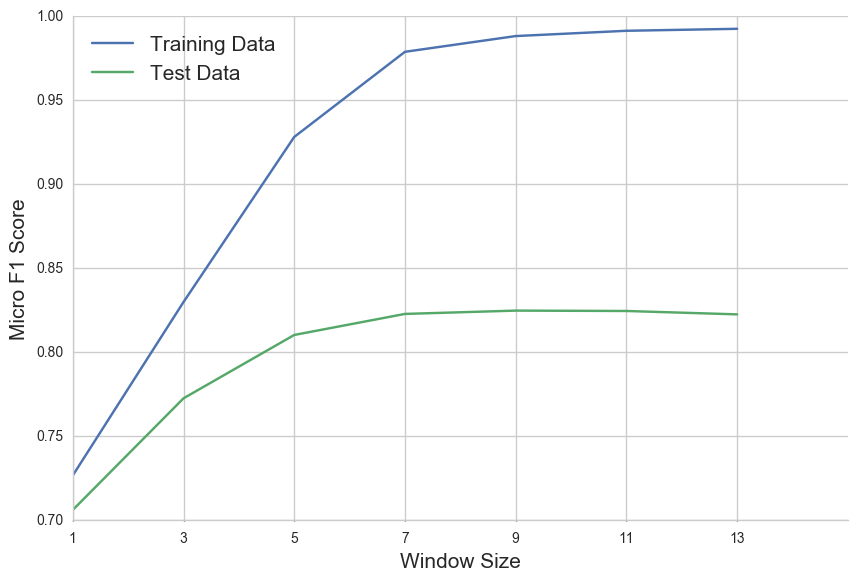

In [20]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

FONT_SIZE = 15

df = pd.merge(
    get_by_window_size(cb_td_df), 
    get_by_window_size(cb_vd_df), 
    on="window_size", suffixes=["_TD", "_VD"])

STYLE = "whitegrid"
sns.set_style(STYLE)
sns.set_style(STYLE, {"xtick.major.size": 1})

fig = plt.figure(figsize=(10,6.5))

x = df["window_size"].values
y_td = df["max(micro_f1_score)_TD"].values
y_vd = df["max(micro_f1_score)_VD"].values

ax1 = fig.add_subplot(111)
ax1.plot(x,y_td, label="Training Data")
ax1.plot(x,y_vd, label="Test Data")

legend = ax1.legend(loc='upper left', shadow=True, fontsize=FONT_SIZE)

ax1.set_xlim([1, 15])
#ax1.set_ylim([0.7, 0.85])
ax1.set_xlabel('Window Size', fontsize=FONT_SIZE)
ax1.set_ylabel('Micro F1 Score', fontsize=FONT_SIZE)

plt.xticks(np.arange(min(x), max(x)+2, 2.0), fontsize=10)
plt.yticks(fontsize=10)

sns.despine()
plt.savefig("/Users/simon.hughes/BitBucket/Dissertation/Dissertation/images/cb_f1_vs_win_size.png")
plt.show()

## Plot TD vs VD F1 Score For SC By Window Size

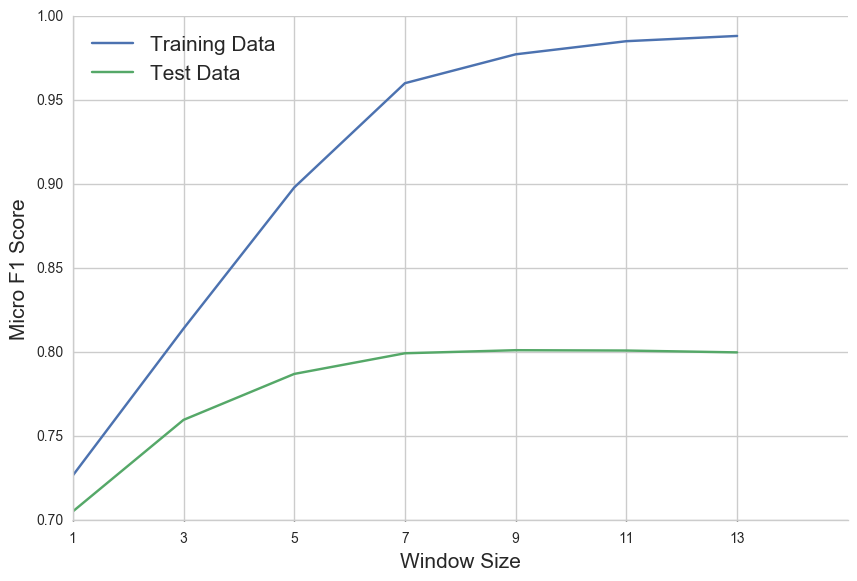

In [22]:
FONT_SIZE = 15

df = pd.merge(
    get_by_window_size(sc_td_df), 
    get_by_window_size(sc_vd_df), 
    on="window_size", suffixes=["_TD", "_VD"])

STYLE = "whitegrid"
sns.set_style(STYLE)
sns.set_style(STYLE, {"xtick.major.size": 1})

fig = plt.figure(figsize=(10,6.5))

x = df["window_size"].values
y_td = df["max(micro_f1_score)_TD"].values
y_vd = df["max(micro_f1_score)_VD"].values

ax1 = fig.add_subplot(111)
ax1.plot(x,y_td, label="Training Data")
ax1.plot(x,y_vd, label="Test Data")

legend = ax1.legend(loc='upper left', shadow=True, fontsize=FONT_SIZE)

ax1.set_xlim([1, 15])
#ax1.set_ylim([0.7, 0.85])
ax1.set_xlabel('Window Size', fontsize=FONT_SIZE)
ax1.set_ylabel('Micro F1 Score', fontsize=FONT_SIZE)

plt.xticks(np.arange(min(x), max(x)+2, 2.0), fontsize=10)
plt.yticks(fontsize=10)

sns.despine()
plt.savefig("/Users/simon.hughes/BitBucket/Dissertation/Dissertation/images/sc_f1_vs_win_size.png")
plt.show()

## Performance By Feature Set Size

In [13]:
def get_by_featureset_size(df):
    return group_by(df, bycols=["count"], agg_map=[("micro_f1_score", "max"),
                                              ("micro_f1_score", "mean"),
                                              #("micro_f1_score", "median"),
                                              #("micro_f1_score", "count"),
                                             ]).sort_values("count")

pd.merge(get_by_featureset_size(cb_vd_df), get_by_featureset_size(sc_vd_df), on="count", suffixes=["_cb", "_sc"])

,count,max(micro_f1_score)_cb,mean(micro_f1_score)_cb,max(micro_f1_score)_sc,mean(micro_f1_score)_sc
0,1,0.813492,0.549772,0.792558,0.554299
1,2,0.819141,0.785654,0.799118,0.768705
2,3,0.822749,0.797302,0.800872,0.779004
3,4,0.823567,0.802461,0.801090,0.782500
4,5,0.824233,0.805277,0.800949,0.785157
5,6,0.824667,0.806893,0.800888,0.775711


### <span style="color:red">NOTE: Optimal SC performance Tails off After 4 features</span>

# Get F1 Score By Num Features As the Optimal Feature Set is Constructed

In [23]:
df = sc_vd_df
max_feats = df["count"].values.max()
df[df["count"] == max_feats].sort_values("micro_f1_score", ascending=False).head(1)["feats"].iloc[0]

[u'fn_pos_wd_feats_stemmed[offset:5]',
 u'fn_pos_ngram_feat_stemmed[ngram_size:2 offset:5]',
 u'extract_brown_cluster',
 u'fn_bow_ngram_feat[ngram_size:1 offset:5]',
 u'extract_dependency_relation',
 u'fn_pos_ngram_feat_stemmed[ngram_size:3 offset:5]']

In [24]:
df

,_id,asof,count,feats,micro_f1_score,micro_precision,micro_recall,weighted_f1_score,window_size,hs_feats
0,58912a66c1a7cb138a051ecb,2017-01-31 18:23:02.294,4,"[fn_pos_wd_feats_stemmed[offset:4], fn_pos_ngr...",0.801090,0.847829,0.759236,0.799806,9,extract_brown_cluster|fn_bow_ngram_feat[ngram_...
1,5891342fc1a7cb138a051ee3,2017-01-31 19:04:47.409,5,"[fn_pos_wd_feats_stemmed[offset:4], fn_pos_ngr...",0.800949,0.848267,0.758632,0.799614,9,extract_brown_cluster|extract_dependency_relat...
2,5890483cc1a7cbe76d2a3314,2017-01-31 02:18:04.114,6,"[fn_pos_wd_feats_stemmed[offset:5], fn_pos_ngr...",0.800888,0.850192,0.756988,0.799517,11,extract_brown_cluster|extract_dependency_relat...
3,589123d7c1a7cb138a051ebd,2017-01-31 17:55:03.460,3,"[fn_pos_wd_feats_stemmed[offset:4], fn_pos_ngr...",0.800872,0.856990,0.751653,0.799248,9,extract_brown_cluster|fn_pos_ngram_feat_stemme...
4,589035afc1a7cbe76d2a32fa,2017-01-31 00:58:55.149,5,"[fn_pos_wd_feats_stemmed[offset:5], fn_pos_ngr...",0.800745,0.849280,0.757458,0.799413,11,extract_brown_cluster|extract_dependency_relat...
5,58903ddac1a7cbe76d2a3306,2017-01-31 01:33:46.896,6,"[fn_pos_wd_feats_stemmed[offset:5], fn_pos_ngr...",0.800723,0.848010,0.758431,0.799422,11,extract_brown_cluster|extract_dependency_relat...
6,58902641c1a7cbe76d2a32e2,2017-01-30 23:53:05.248,4,"[fn_pos_wd_feats_stemmed[offset:5], fn_pos_ngr...",0.800630,0.847593,0.758599,0.799421,11,extract_brown_cluster|fn_bow_ngram_feat[ngram_...
7,58913119c1a7cb138a051edd,2017-01-31 18:51:37.213,5,"[fn_pos_wd_feats_stemmed[offset:4], fn_pos_ngr...",0.800545,0.846816,0.759068,0.799303,9,extract_brown_cluster|fn_bow_ngram_feat[ngram_...
8,5890311ac1a7cbe76d2a32f4,2017-01-31 00:39:22.224,5,"[fn_pos_wd_feats_stemmed[offset:5], fn_pos_ngr...",0.800439,0.847290,0.758498,0.799199,11,extract_brown_cluster|fn_bow_ngram_feat[ngram_...
9,589129b7c1a7cb138a051ec9,2017-01-31 18:20:07.726,4,"[fn_pos_wd_feats_stemmed[offset:4], fn_pos_ngr...",0.800435,0.854385,0.752894,0.798835,9,extract_brown_cluster|fn_pos_ngram_feat_stemme...


In [25]:
df.sort_values("micro_f1_score", ascending=False)[["micro_f1_score", "count", "window_size", "feats"]]

,micro_f1_score,count,window_size,feats
0,0.801090,4,9,"[fn_pos_wd_feats_stemmed[offset:4], fn_pos_ngr..."
1,0.800949,5,9,"[fn_pos_wd_feats_stemmed[offset:4], fn_pos_ngr..."
2,0.800888,6,11,"[fn_pos_wd_feats_stemmed[offset:5], fn_pos_ngr..."
3,0.800872,3,9,"[fn_pos_wd_feats_stemmed[offset:4], fn_pos_ngr..."
4,0.800745,5,11,"[fn_pos_wd_feats_stemmed[offset:5], fn_pos_ngr..."
5,0.800723,6,11,"[fn_pos_wd_feats_stemmed[offset:5], fn_pos_ngr..."
6,0.800630,4,11,"[fn_pos_wd_feats_stemmed[offset:5], fn_pos_ngr..."
7,0.800545,5,9,"[fn_pos_wd_feats_stemmed[offset:4], fn_pos_ngr..."
8,0.800439,5,11,"[fn_pos_wd_feats_stemmed[offset:5], fn_pos_ngr..."
9,0.800435,4,9,"[fn_pos_wd_feats_stemmed[offset:4], fn_pos_ngr..."


In [17]:
df.sort_values("micro_f1_score", ascending=False).head(1)["feats"].iloc[0]

[u'fn_pos_wd_feats_stemmed[offset:4]',
 u'fn_pos_ngram_feat_stemmed[ngram_size:2 offset:4]',
 u'extract_brown_cluster',
 u'fn_bow_ngram_feat[ngram_size:1 offset:4]']

In [27]:
cols_filter = "count,new_feat,micro_f1_score,micro_recall,micro_precision".split(",")

def get_f1_by_feat_count(df):
    #max_feats = df["count"].values.max()
    
    top_feats = df.sort_values("micro_f1_score", ascending=False).iloc[0]["feats"]

    rows = []
    for i in range(0,len(top_feats)):
        new_feat = top_feats[i]
        upto = top_feats[:i+1]
        hs = hash_feats(upto)
        new_row = df[df["hs_feats"] == hs].iloc[0]
        new_row["new_feat"] = feat_name(new_feat)
        copy = {}
        for k in new_row.keys():
            copy[str(k).strip()] = new_row[k]
        rows.append(copy)

    df_f1_by_feat_count = pd.DataFrame(rows)
    return df_f1_by_feat_count[cols_filter]

df_f1_score_by_feat_size= pd.merge(get_f1_by_feat_count(cb_vd_df), get_f1_by_feat_count(sc_vd_df), on="count", how="outer", suffixes=("_CB", "_SC"))
df_f1_score_by_feat_size
# Note that the optimal feature set for SC is only of size 4

,count,new_feat_CB,micro_f1_score_CB,micro_recall_CB,micro_precision_CB,new_feat_SC,micro_f1_score_SC,micro_recall_SC,micro_precision_SC
0,1,pos_wd_feats_stemmed[offset:4],0.812696,0.746745,0.891425,pos_wd_feats_stemmed[offset:4],0.791081,0.739942,0.849815
1,2,pos_ngram_feat_stemmed[ngram_size:2offset:4],0.819141,0.752458,0.898793,pos_ngram_feat_stemmed[ngram_size:2offset:4],0.799118,0.747861,0.857918
2,3,bow_ngram_feat[ngram_size:1offset:4],0.822749,0.768574,0.885141,extract_brown_cluster,0.800872,0.751653,0.856990
3,4,extract_brown_cluster,0.823567,0.770588,0.884369,bow_ngram_feat[ngram_size:1offset:4],0.801090,0.759236,0.847829
4,5,pos_ngram_feat_stemmed[ngram_size:3offset:4],0.824233,0.770889,0.885508,NaN,NaN,NaN,NaN
5,6,extract_dependency_relation,0.824667,0.770799,0.886629,NaN,NaN,NaN,NaN


In [28]:
# Round to 4 d.p. for printing
df = df_f1_score_by_feat_size["count,new_feat_CB,micro_f1_score_CB,new_feat_SC,micro_f1_score_SC".split(",")].copy()
df["micro_f1_score_CB"] = df["micro_f1_score_CB"].apply(lambda d: "{0:.4f}".format(d))  
df["micro_f1_score_SC"] = df["micro_f1_score_SC"].apply(lambda d: "{0:.4f}".format(d))  
df

,count,new_feat_CB,micro_f1_score_CB,new_feat_SC,micro_f1_score_SC
0,1,pos_wd_feats_stemmed[offset:4],0.8127,pos_wd_feats_stemmed[offset:4],0.7911
1,2,pos_ngram_feat_stemmed[ngram_size:2offset:4],0.8191,pos_ngram_feat_stemmed[ngram_size:2offset:4],0.7991
2,3,bow_ngram_feat[ngram_size:1offset:4],0.8227,extract_brown_cluster,0.8009
3,4,extract_brown_cluster,0.8236,bow_ngram_feat[ngram_size:1offset:4],0.8011
4,5,pos_ngram_feat_stemmed[ngram_size:3offset:4],0.8242,NaN,nan
5,6,extract_dependency_relation,0.8247,NaN,nan


# Plot F1 Score Against # Feature Sets

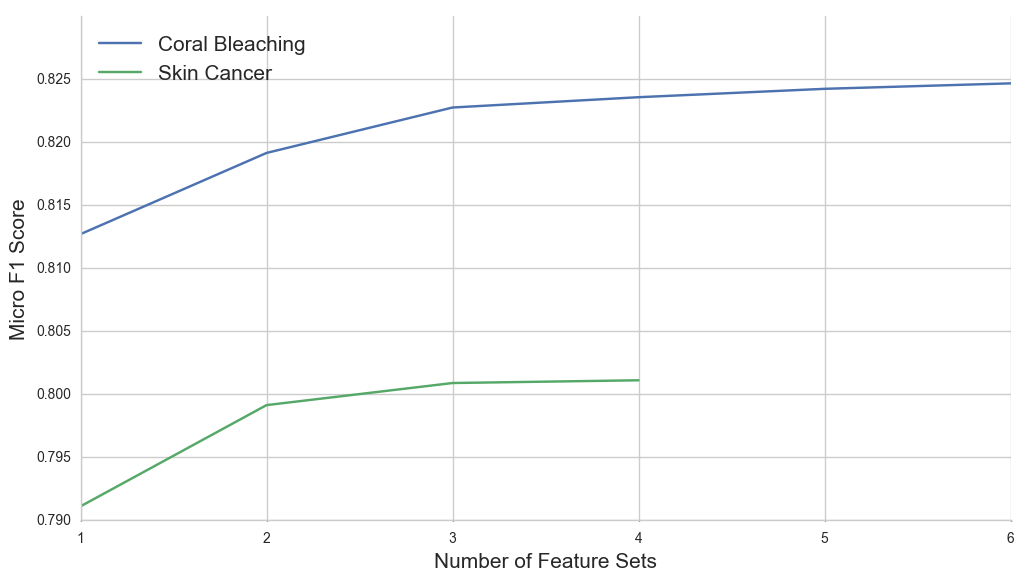

In [29]:
FONT_SIZE = 15

df = df_f1_score_by_feat_size

STYLE = "whitegrid"
sns.set_style(STYLE)
sns.set_style(STYLE, {"xtick.major.size": 1})

fig = plt.figure(figsize=(12,6.5))

x = df["count"].values
y_cb = df["micro_f1_score_CB"].values
y_sc = df["micro_f1_score_SC"].values

ax1 = fig.add_subplot(111)
ax1.plot(x,y_cb, label="Coral Bleaching")
ax1.plot(x,y_sc, label="Skin Cancer")

legend = ax1.legend(loc='upper left', shadow=True, fontsize=FONT_SIZE)

ax1.set_xlim([1, 6])
ax1.set_ylim([0.79, 0.83])
ax1.set_xlabel('Number of Feature Sets', fontsize=FONT_SIZE)
ax1.set_ylabel('Micro F1 Score', fontsize=FONT_SIZE)

plt.xticks(np.arange(min(x), max(x)+1, 1.0), fontsize=10)
sns.despine()

plt.savefig("/Users/simon.hughes/BitBucket/Dissertation/Dissertation/images/f1_score_by_num_feats.png")
plt.show()

## Generate Rows for LaTex Table

In [33]:
for i, row in df_f1_score_by_feat_size.iterrows():
    #pprint(row)
    
    feats_CB = format_lbl(row["new_feat_CB"])
    micro_f1_score_CB = row["micro_f1_score_CB"]
    
    feats_SC = format_lbl(str(row["new_feat_SC"]))
    if feats_SC == "nan":
        feats_SC = "-"
        
    micro_f1_score_SC = row["micro_f1_score_SC"]
    if str(micro_f1_score_SC) != "nan":
        micro_f1_score_SC = "{0:0.4f}".format(micro_f1_score_SC)
    else:
        micro_f1_score_SC = "-"
    count = row["count"]
    print("{count} & {feat_cb} & {cb_f1:0.4f} & & {feat_sc} & {sc_f1}\\\\"\
          .format(count=count,feat_cb=feats_CB, cb_f1=micro_f1_score_CB,
                  feat_sc=feats_SC, sc_f1=micro_f1_score_SC))

1 & pos wd feats stemmed offset:4 & 0.8127 & & pos wd feats stemmed offset:4 & 0.7911\\
2 & pos ngram feat stemmed ngram size:2offset:4 & 0.8191 & & pos ngram feat stemmed ngram size:2offset:4 & 0.7991\\
3 & bow ngram feat ngram size:1offset:4 & 0.8227 & & extract brown cluster & 0.8009\\
4 & extract brown cluster & 0.8236 & & bow ngram feat ngram size:1offset:4 & 0.8011\\
5 & pos ngram feat stemmed ngram size:3offset:4 & 0.8242 & & - & -\\
6 & extract dependency relation & 0.8247 & & - & -\\


## Sanity Check - Do Any Datasets have Duplicate Feature Sets with Different F1 Scores?

In [34]:
#SH: There were some issues with the CB_VD dataset initially for a couple of collections
for df in [cb_td_df, cb_vd_df, sc_td_df, sc_vd_df]:
    gb = group_by(df, bycols=["hs_feats"], agg_map=[
        ("micro_f1_score", "count"),
        ("micro_f1_score", "min"),
        ("micro_f1_score", "max"),
    ])
    gb = gb[gb["count(micro_f1_score)"] > 1]
    miss_match = gb[gb["min(micro_f1_score)"] != gb["max(micro_f1_score)"]]
    
    assert len(miss_match) == 0, "Some errors occurred during data capture"